In [3]:
# Importing essential libraries
import numpy as np
import pandas as pd

In [4]:
# Loading the dataset
df = pd.read_csv('diabetes.csv')

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df.shape

(768, 9)

In [8]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [11]:
df = df.rename(columns={'DiabetesPedigreeFunction':'DPF'})

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:xlabel='Outcome', ylabel='count'>

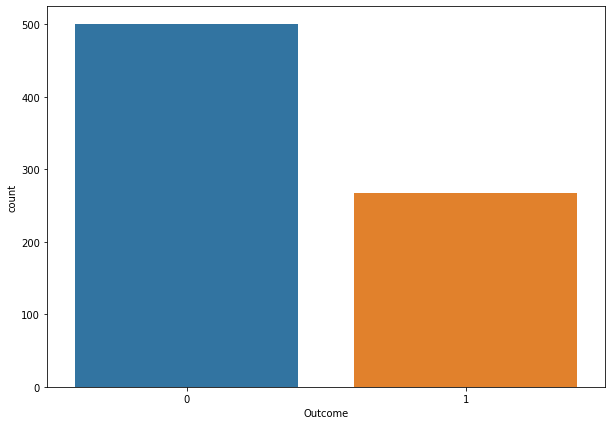

In [14]:
plt.figure(figsize=(10,7))
sns.countplot(x='Outcome', data=df)

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='Outcome')
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (614, 8), X_test size: (154, 8)


In [16]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [17]:
# Using GridSearchCV to find the best algorithm for this problem

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [21]:
def find_best_model(X, y):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(solver='lbfgs', multi_class='auto'),
            'parameters': {
                'C': [1,5,10]
               }
        },
        
        'decision_tree': {
            'model': DecisionTreeClassifier(splitter='best'),
            'parameters': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [5,10]
            }
        },
        
        'random_forest': {
            'model': RandomForestClassifier(criterion='gini'),
            'parameters': {
                'n_estimators': [10,15,20,50,100,200]
            }
        },
        
        'svm': {
            'model': SVC(gamma='auto'),
            'parameters': {
                'C': [1,10,20],
                'kernel': ['rbf','linear']
            }
        }

    }
    
    scores = [] 
    cv_shuffle = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
        
    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = cv_shuffle, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'best_parameters': gs.best_params_,
            'score': gs.best_score_
        })
        
    return pd.DataFrame(scores, columns=['model','best_parameters','score'])

find_best_model(X_train, y_train)


,model,best_parameters,score
0,logistic_regression,{'C': 1},0.769106
1,decision_tree,"{'criterion': 'entropy', 'max_depth': 10}",0.731707
2,random_forest,{'n_estimators': 100},0.752846
3,svm,"{'C': 1, 'kernel': 'linear'}",0.773984


In [22]:
from sklearn.model_selection import cross_val_score
classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X_train,y_train)
score = cross_val_score(classifier, X_train, y_train, cv=5)
print(score)

[0.70731707 0.79674797 0.75609756 0.70731707 0.75409836]


In [33]:
round(np.mean(score),2)*100

74.0

In [31]:
print('Average Accuracy : {}%'.format(round(sum(score)*100/len(score)), 3))

Average Accuracy : 74%


In [34]:
# Creating Random Forest Model
classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=0)

# Model Evaluation

In [35]:
# Creating a confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[97, 10],
       [22, 25]], dtype=int64)

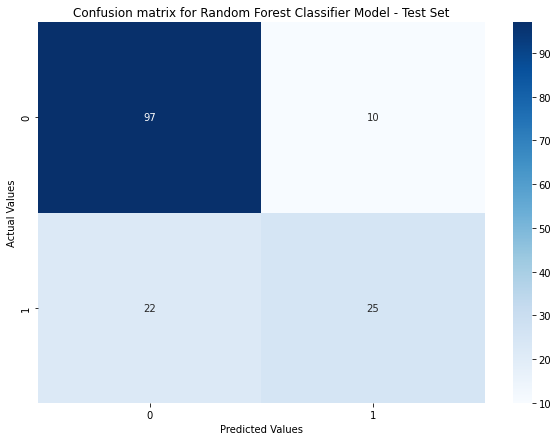

In [36]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [37]:
# Accuracy Score
score = round(accuracy_score(y_test, y_pred),4)*100
print("Accuracy on test set: {}%".format(score))

Accuracy on test set: 79.22%


In [38]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       107
           1       0.71      0.53      0.61        47

    accuracy                           0.79       154
   macro avg       0.76      0.72      0.73       154
weighted avg       0.78      0.79      0.78       154



In [39]:
# Creating a confusion matrix for training set
y_train_pred = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[393,   0],
       [  3, 218]], dtype=int64)

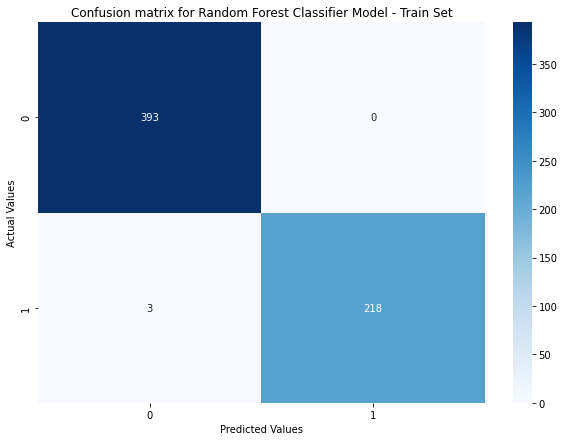

In [40]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Train Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

# Predictions

In [41]:
def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age):
    preg = int(Pregnancies)
    glucose = float(Glucose)
    bp = float(BloodPressure)
    st = float(SkinThickness)
    insulin = float(Insulin)
    bmi = float(BMI)
    dpf = float(DPF)
    age = int(Age)
    
    x= [[preg, glucose, bp, st, insulin, bmi, dpf, age]]
    x= sc.transform(x)
    
    return classifier.predict(x)

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
prediction = predict_diabetes(2, 81, 72, 15, 76, 30.1, 0.547, 25)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")


Great! You don't have diabetes.


In [47]:
prediction = predict_diabetes(1, 117, 88, 24, 145, 34.5, 0.403, 40)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Oops! You have diabetes.


In [48]:
prediction = predict_diabetes(5, 120, 92, 10, 81, 26.1, 0.551, 67)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Great! You don't have diabetes.
